# Testing Algorithms on Electrical Energy Output of Power Plant Dataset
* dataset: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant


In [1]:
import pandas as pd 
import numpy as np 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

In [2]:
#importing data
data = pd.read_excel('datasets/CCP.xlsx')

In [3]:
data.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [19]:
#storing the label 
energy_output = data['PE']

#removing label from dataframe
data.drop(['PE'], axis=1, inplace=True)

#dropping columns with missing rows 
data.dropna(inplace=True)

In [20]:
energy_output

0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
9563    1.0
9564    1.0
9565    0.0
9566    0.0
9567    0.0
Name: PE, Length: 9568, dtype: float64

In [21]:
#standardizing data
continuous_cols = ['AT','V','AP','RH']
features = data[continuous_cols]
scaler = StandardScaler().fit(features.values)
data[continuous_cols] = scaler.transform(features.values)



In [22]:
data.head()

,AT,V,AP,RH
0,-0.629519,-0.987297,1.820488,-0.009519
1,0.741909,0.681045,1.141863,-0.974621
2,-1.951297,-1.173018,-0.185078,1.289840
3,0.162205,0.237203,-0.508393,0.228160
4,-1.185069,-1.322539,-0.678470,1.596699


In [23]:
label_mean = np.mean(energy_output)

In [24]:
label_mean

0.45829849498327757

In [25]:
for i in range(len(Y)):
    if (Y[i] >= label_mean):
        Y[i] = 1
    else:
        Y[i] = 0

In [26]:
Y = Y.astype(int)

In [28]:
X = data

In [29]:
#creating 5 sets of training and test data 
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, train_size=5000)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y, train_size=5000)
X3_train, X3_test, y3_train, y3_test = train_test_split(X, Y, train_size=5000)
X4_train, X4_test, y4_train, y4_test = train_test_split(X, Y, train_size=5000)
X5_train, X5_test, y5_train, y5_test = train_test_split(X, Y, train_size=5000)

In [30]:
#creating arrays of training and test sets 
train_X_sets = [X1_train,X2_train,X3_train,X4_train,X5_train]
test_X_sets = [X1_test,X2_test,X3_test,X4_test,X5_test]

#creating arrays of training and test sets 
train_y_sets = [y1_train,y2_train,y3_train,y4_train,y5_train]
test_y_sets = [y1_test,y2_test,y3_test,y4_test,y5_test]

### Logistic Regression

In [32]:
#creating a pipeline in order to grid search 
pipe = Pipeline([('classifier', LogisticRegression())])

# Create search space of candidate learning algorithms and their hyperparameters
# note lbfgs can't do l1, and if you pass penalty='none' it expects no C value
search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-8, 4, 11)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-8, 4, 11)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}
                ]
# Create grid search 
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc', 'f1'], refit=False,
                   verbose=0)

In [34]:
#fitting the models with 5 fold cross validation
logreg_models = []

for i in range(5):
    logreg_models.append(clf.fit(train_X_sets[i],train_y_sets[i]))

In [35]:
#initializing array of training and test set predicted values
logreg_train_roc_pred = []
logreg_test_roc_pred = []

logreg_train_acc_pred = []
logreg_test_acc_pred = []

logreg_train_f1_pred = []
logreg_test_f1_pred = []

In [36]:
for i in range(5):
    proc = logreg_models[i].cv_results_['params'][ np.argmin(logreg_models[i].cv_results_['rank_test_roc_auc'])]
    pacc = logreg_models[i].cv_results_['params'][ np.argmin(logreg_models[i].cv_results_['rank_test_accuracy'])]
    pf1 = logreg_models[i].cv_results_['params'][ np.argmin(logreg_models[i].cv_results_['rank_test_f1'])]
    
    pipe.set_params(**proc)
    pipe.fit(train_X_sets[i],train_y_sets[i])

    logreg_train_roc_pred.append(pipe.predict(train_X_sets[i]))
    logreg_test_roc_pred.append(pipe.predict(test_X_sets[i]))
    
    pipe.set_params(**pacc)
    pipe.fit(train_X_sets[i],train_y_sets[i])
    
    logreg_train_acc_pred.append(pipe.predict(train_X_sets[i]))
    logreg_test_acc_pred.append(pipe.predict(test_X_sets[i]))
    
    pipe.set_params(**pf1)
    pipe.fit(train_X_sets[i],train_y_sets[i])
    
    logreg_train_f1_pred.append(pipe.predict(train_X_sets[i]))
    logreg_test_f1_pred.append(pipe.predict(test_X_sets[i]))

In [37]:
#initializing scores arrays for each metric, random forest on adult dataset
logreg_train_roc_scores = []
logreg_train_acc_scores = []
logreg_train_f1_scores = []
logreg_test_roc_scores = []
logreg_test_acc_scores = []
logreg_test_f1_scores = []

In [38]:
#populating the scores arrays 
for i in range(5):
    logreg_train_roc_scores.append(roc_auc_score(train_y_sets[i],logreg_train_roc_pred[i]))
    logreg_train_acc_scores.append(accuracy_score(train_y_sets[i],logreg_train_acc_pred[i]))
    logreg_train_f1_scores.append(f1_score(train_y_sets[i],logreg_train_f1_pred[i]))
    logreg_test_roc_scores.append(roc_auc_score(test_y_sets[i],logreg_test_roc_pred[i]))
    logreg_test_acc_scores.append(accuracy_score(test_y_sets[i],logreg_test_acc_pred[i]))
    logreg_test_f1_scores.append(f1_score(test_y_sets[i],logreg_test_f1_pred[i]))

In [39]:
#mean of each metric across trials
logreg_train_mean_roc = np.mean(logreg_train_roc_scores)
logreg_train_mean_acc = np.mean(logreg_train_acc_scores)
logreg_train_mean_f1 = np.mean(logreg_train_f1_scores)
logreg_test_mean_roc = np.mean(logreg_test_roc_scores)
logreg_test_mean_acc = np.mean(logreg_test_acc_scores)
logreg_test_mean_f1 = np.mean(logreg_test_f1_scores)

In [40]:
#mean across metrics 
logreg_metric_mean_test = np.mean([logreg_test_roc_scores,logreg_test_acc_scores,logreg_test_f1_scores])
logreg_metric_mean_train = np.mean([logreg_train_roc_scores,logreg_train_acc_scores,logreg_train_f1_scores])

### Random Forest

In [41]:
#creating a random forest object in order to grid search 
pipe2 =  RandomForestClassifier(criterion='entropy')

#setting the possible options for hyperparameters 
params = [{'n_estimators':[1024],'max_features':[1,2,4]}]

#creating a gridsearch object 
clf2 = GridSearchCV(pipe2, params, cv=StratifiedKFold(n_splits=5), scoring=['accuracy', 'roc_auc', 'f1'], refit=False, verbose=0)

In [42]:
#fitting the models with 5 fold cross validation
rf_models = []

for i in range(5):
    rf_models.append(clf2.fit(train_X_sets[i],train_y_sets[i]))

In [43]:
#initializing array of training and test set predicted values
rf_train_roc_pred = []
rf_test_roc_pred = []

rf_train_acc_pred = []
rf_test_acc_pred = []

rf_train_f1_pred = []
rf_test_f1_pred = []

In [44]:
for i in range(5):
    proc = rf_models[i].cv_results_['params'][ np.argmin(rf_models[i].cv_results_['rank_test_roc_auc'])]
    pacc = rf_models[i].cv_results_['params'][ np.argmin(rf_models[i].cv_results_['rank_test_accuracy'])]
    pf1 = rf_models[i].cv_results_['params'][ np.argmin(rf_models[i].cv_results_['rank_test_f1'])]
    
    pipe2.set_params(**proc)
    pipe2.fit(train_X_sets[i],train_y_sets[i])

    rf_train_roc_pred.append(pipe2.predict(train_X_sets[i]))
    rf_test_roc_pred.append(pipe2.predict(test_X_sets[i]))
    
    pipe2.set_params(**pacc)
    pipe2.fit(train_X_sets[i],train_y_sets[i])
    
    rf_train_acc_pred.append(pipe2.predict(train_X_sets[i]))
    rf_test_acc_pred.append(pipe2.predict(test_X_sets[i]))
    
    pipe2.set_params(**pf1)
    pipe2.fit(train_X_sets[i],train_y_sets[i])
    
    rf_train_f1_pred.append(pipe2.predict(train_X_sets[i]))
    rf_test_f1_pred.append(pipe2.predict(test_X_sets[i]))

In [45]:
#initializing scores arrays for each metric, random forest on adult dataset
rf_train_roc_scores = []
rf_train_acc_scores = []
rf_train_f1_scores = []
rf_test_roc_scores = []
rf_test_acc_scores = []
rf_test_f1_scores = []

In [46]:
#populating the scores arrays 
for i in range(5):
    rf_train_roc_scores.append(roc_auc_score(train_y_sets[i],rf_train_roc_pred[i]))
    rf_train_acc_scores.append(accuracy_score(train_y_sets[i],rf_train_acc_pred[i]))
    rf_train_f1_scores.append(f1_score(train_y_sets[i],rf_train_f1_pred[i]))
    rf_test_roc_scores.append(roc_auc_score(test_y_sets[i],rf_test_roc_pred[i]))
    rf_test_acc_scores.append(accuracy_score(test_y_sets[i],rf_test_acc_pred[i]))
    rf_test_f1_scores.append(f1_score(test_y_sets[i],rf_test_f1_pred[i]))

In [47]:
#mean of each metric across trials
rf_train_mean_roc = np.mean(rf_train_roc_scores)
rf_train_mean_acc = np.mean(rf_train_acc_scores)
rf_train_mean_f1 = np.mean(rf_train_f1_scores)
rf_test_mean_roc = np.mean(rf_test_roc_scores)
rf_test_mean_acc = np.mean(rf_test_acc_scores)
rf_test_mean_f1 = np.mean(rf_test_f1_scores)

In [48]:
#mean across metrics 
rf_metric_mean_test = np.mean([rf_test_roc_scores,rf_test_acc_scores,rf_test_f1_scores])
rf_metric_mean_train = np.mean([rf_train_roc_scores,rf_train_acc_scores,rf_train_f1_scores])

### kNN

In [49]:
#creating a k Nearest Neighbors object in order to grid search 
pipe3 =  KNeighborsClassifier()
step = 500/26
k = np.arange(1,500,step,dtype=int)
k_params = [{'n_neighbors':k,'weights':['uniform','distance'],'metric':['euclidean','manhattan']}]

clf3 = GridSearchCV(pipe3, k_params, cv=StratifiedKFold(n_splits=5), scoring=['accuracy', 'roc_auc', 'f1'], refit=False, verbose=0)

In [50]:
#fitting the models with 5 fold cross validation
knn_models = []

for i in range(5):
    knn_models.append(clf3.fit(train_X_sets[i],train_y_sets[i]))

In [51]:
#initializing array of training and test set predicted values
knn_train_roc_pred = []
knn_test_roc_pred = []

knn_train_acc_pred = []
knn_test_acc_pred = []

knn_train_f1_pred = []
knn_test_f1_pred = []

In [52]:
for i in range(5):
    proc = knn_models[i].cv_results_['params'][ np.argmin(knn_models[i].cv_results_['rank_test_roc_auc'])]
    pacc = knn_models[i].cv_results_['params'][ np.argmin(knn_models[i].cv_results_['rank_test_accuracy'])]
    pf1 = knn_models[i].cv_results_['params'][ np.argmin(knn_models[i].cv_results_['rank_test_f1'])]
    
    pipe3.set_params(**proc)
    pipe3.fit(train_X_sets[i],train_y_sets[i])

    knn_train_roc_pred.append(pipe3.predict(train_X_sets[i]))
    knn_test_roc_pred.append(pipe3.predict(test_X_sets[i]))
    
    pipe3.set_params(**pacc)
    pipe3.fit(train_X_sets[i],train_y_sets[i])
    
    knn_train_acc_pred.append(pipe3.predict(train_X_sets[i]))
    knn_test_acc_pred.append(pipe3.predict(test_X_sets[i]))
    
    pipe3.set_params(**pf1)
    pipe3.fit(train_X_sets[i],train_y_sets[i])
    
    knn_train_f1_pred.append(pipe3.predict(train_X_sets[i]))
    knn_test_f1_pred.append(pipe3.predict(test_X_sets[i]))

In [53]:
#initializing scores arrays for each metric, random forest on adult dataset
knn_train_roc_scores = []
knn_train_acc_scores = []
knn_train_f1_scores = []
knn_test_roc_scores = []
knn_test_acc_scores = []
knn_test_f1_scores = []

In [54]:
#populating the scores arrays 
for i in range(5):
    knn_train_roc_scores.append(roc_auc_score(train_y_sets[i],knn_train_roc_pred[i]))
    knn_train_acc_scores.append(accuracy_score(train_y_sets[i],knn_train_acc_pred[i]))
    knn_train_f1_scores.append(f1_score(train_y_sets[i],knn_train_f1_pred[i]))
    knn_test_roc_scores.append(roc_auc_score(test_y_sets[i],knn_test_roc_pred[i]))
    knn_test_acc_scores.append(accuracy_score(test_y_sets[i],knn_test_acc_pred[i]))
    knn_test_f1_scores.append(f1_score(test_y_sets[i],knn_test_f1_pred[i]))

In [55]:
#mean of each metric across trials
knn_train_mean_roc = np.mean(knn_train_roc_scores)
knn_train_mean_acc = np.mean(knn_train_acc_scores)
knn_train_mean_f1 = np.mean(knn_train_f1_scores)
knn_test_mean_roc = np.mean(knn_test_roc_scores)
knn_test_mean_acc = np.mean(knn_test_acc_scores)
knn_test_mean_f1 = np.mean(knn_test_f1_scores)

In [56]:
#mean across metrics 
knn_metric_mean_test = np.mean([knn_test_roc_scores,knn_test_acc_scores,knn_test_f1_scores])
knn_metric_mean_train = np.mean([knn_train_roc_scores,knn_train_acc_scores,knn_train_f1_scores])

In [111]:
pd.DataFrame(rf_models[0].cv_results_).describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,...,std_test_roc_auc,rank_test_roc_auc,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0000,3.000000,...,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,5.329298,0.550261,0.345366,0.020590,0.971000,0.979667,0.960333,0.968333,0.9720,0.970267,...,0.002056,2.0,0.968239,0.977647,0.956617,0.965714,0.969653,0.967574,0.006896,2.0
std,2.213023,0.633653,0.030631,0.012359,0.001732,0.000577,0.000577,0.003055,0.0010,0.000757,...,0.000358,1.0,0.001839,0.000649,0.000579,0.003340,0.001084,0.000812,0.000480,1.0
min,3.712373,0.146326,0.315600,0.012530,0.970000,0.979000,0.960000,0.965000,0.9710,0.969400,...,0.001807,1.0,0.967177,0.976898,0.956236,0.962080,0.968581,0.966649,0.006362,1.0
25%,4.068236,0.185107,0.329652,0.013476,0.970000,0.979500,0.960000,0.967000,0.9715,0.970000,...,0.001851,1.5,0.967177,0.977460,0.956284,0.964247,0.969106,0.967278,0.006698,1.5
50%,4.424100,0.223887,0.343704,0.014421,0.970000,0.980000,0.960000,0.969000,0.9720,0.970600,...,0.001895,2.0,0.967177,0.978022,0.956332,0.966414,0.969631,0.967908,0.007033,2.0
75%,6.137761,0.752228,0.360249,0.024620,0.971500,0.980000,0.960500,0.970000,0.9725,0.970700,...,0.002180,2.5,0.968770,0.978022,0.956808,0.967531,0.970189,0.968037,0.007162,2.5
max,7.851423,1.280569,0.376794,0.034820,0.973000,0.980000,0.961000,0.971000,0.9730,0.970800,...,0.002466,3.0,0.970362,0.978022,0.957284,0.968649,0.970748,0.968166,0.007292,3.0


In [115]:
knn_models[3].cv_results_['params'][ np.argmin(knn_models[i].cv_results_['rank_test_accuracy'])]

{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}

In [118]:
from sklearn import metrics

In [123]:
a,b,_ = metrics.roc_curve(rf_test_roc_pred[0],test_y_sets[0])

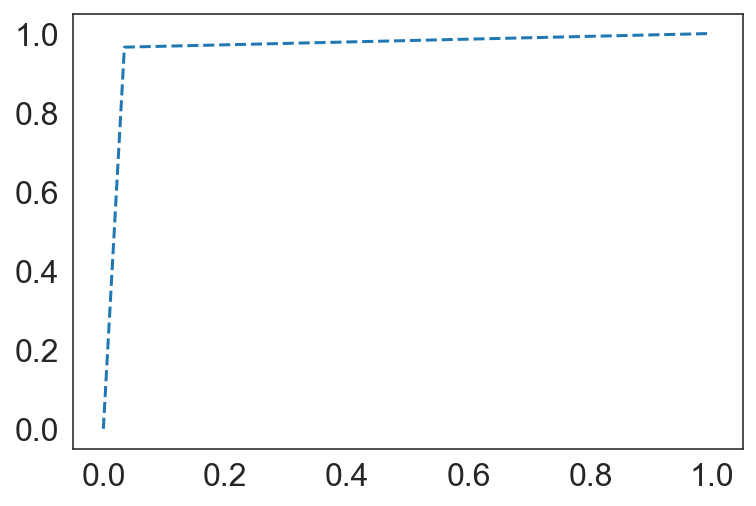

In [124]:
plt.plot(a, b, linestyle='--')